In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

## Data for Plot 1 - 5

In [2]:
df = pd.read_csv('Music Sales.csv', index_col=None)

### Plot 1: Horizontal Bar Plot

In [3]:
df_EA=df[df['Region'].isin(['Europe', 'Asia'])].copy()
df_genre = df_EA.groupby(['Genre'])['Quantity'].sum().reset_index()
df_genre.sort_values(by=['Quantity'], ascending=False, inplace=True)

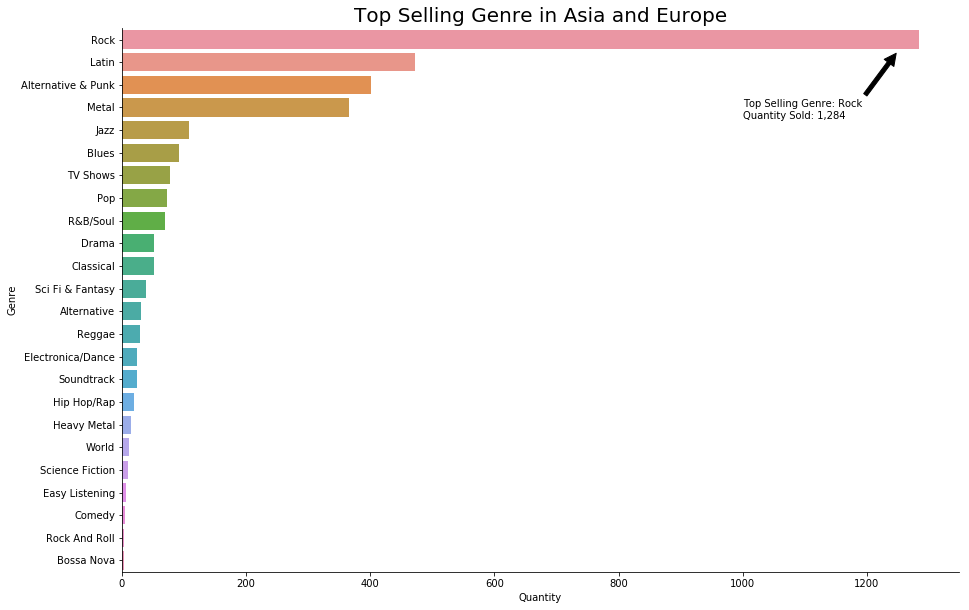

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
ax = fig.gca()
sns.barplot(y='Genre', x='Quantity', data=df_genre, ax=ax)
ax.set_title('Top Selling Genre in Asia and Europe', size=20)
ax.annotate('Top Selling Genre: Rock\nQuantity Sold: 1,284', 
            xy = (1250,0.5), xytext=(1000,3.5), arrowprops=dict(facecolor='black', shrink=0.05))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [5]:
from matplotlib.patches import Rectangle

bars = [r for r in ax.get_children() if type(r)==Rectangle]
colors = [c.get_facecolor() for c in bars[:-1]]
df_genre['colors'] = colors

### Plot 2: Stacked Horizontal Bar Plot

In [6]:
df_rank = df_EA.groupby(['Artist'])['Quantity'].sum().reset_index()
df_rank['Rank'] = df_rank['Quantity'].rank(method='dense', ascending=False) 
df_rank_genre = df_EA.groupby(['Artist', 'Genre'])['Quantity'].sum().reset_index()
df_rank_genre=pd.merge(df_rank_genre, df_rank[['Artist', 'Rank']], on='Artist', how='left')
df_rank_genre.sort_values(by='Rank', inplace=True)
df_top20 = df_rank_genre.loc[df_rank_genre['Rank'] <= 20,
                             ['Artist', 'Genre', 'Quantity']].pivot(columns='Genre',
                                                                    index='Artist',
                                                                    values='Quantity')

df_top20['total'] = df_top20.sum(axis=1)
df_top20.sort_values(by=['total', 'Artist'], ascending=[True, False], inplace=True)
df_top20.drop('total', axis=1, inplace=True)
colorset = df_genre[df_genre['Genre'].isin(df_top20.columns)].sort_values('Genre')['colors']

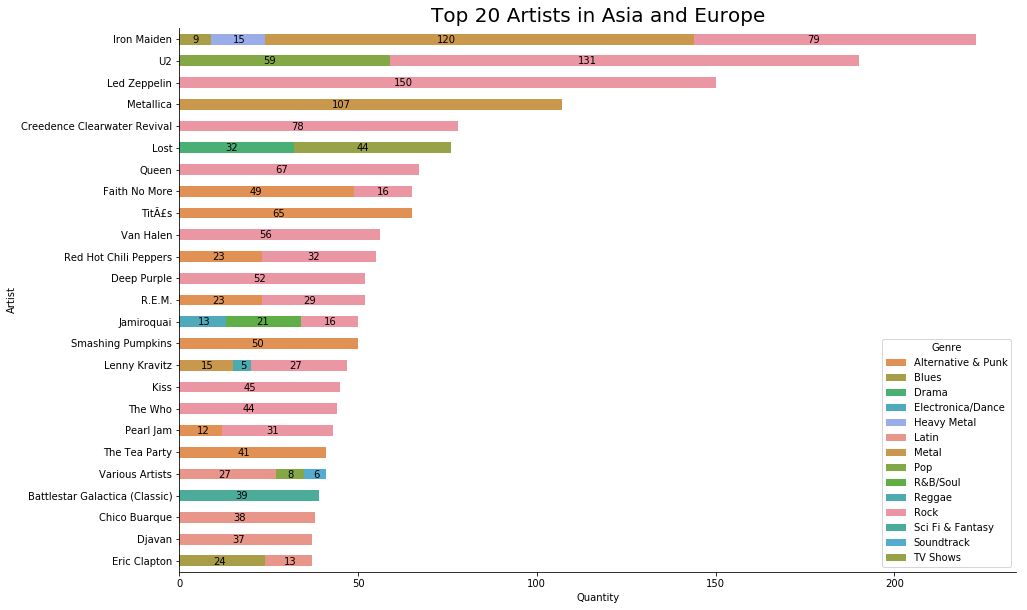

In [7]:
ax = df_top20.plot.barh(stacked=True, figsize=(15, 10), color=colorset)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if width > 0:
        ax.annotate(f'{width:.0f}', (p.get_x()+0.40*width,
                                     p.get_y()+.17*height), color='black', fontsize=10)
plt.title('Top 20 Artists in Asia and Europe', size=20)
plt.xlabel('Quantity')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Plot 3: Time Series

In [8]:
df_EA['InvoiceDate'] = pd.to_datetime(df_EA['InvoiceDate'])
df_EA['InvoiceDate_year_month'] = pd.to_datetime(df_EA['InvoiceDate']).dt.strftime("%Y-%m")
# subset the data needed for the plot
df_3genres=df_EA[df_EA['Genre'].isin(['Alternative & Punk','Heavy Metal', 'Rock'])]
# get the summary
df_3genres_summary = df_3genres.groupby(['Genre', 'InvoiceDate_year_month'])['Sales'].sum().reset_index()
# set the template
t = pd.date_range('2008-01-01', '2012-12-31', freq='MS')
order=list(np.arange(60))*3
df_3genres_template=pd.DataFrame(list(itertools.product(['Rock','Alternative & Punk','Heavy Metal'], t)), 
                                 columns=['Genre', 'InvoiceDate'])
df_3genres_template['order']=order
df_3genres_template['InvoiceDate_year_month'] = pd.to_datetime(df_3genres_template['InvoiceDate']).dt.strftime("%Y-%m")
# merge the summary with the template
df_3genres_summary = pd.merge(df_3genres_template, df_3genres_summary, 
                               on=['Genre', 'InvoiceDate_year_month'], how='left')
colorset2 = df_genre[df_genre['Genre'].isin(df_3genres_summary['Genre'])].sort_values('Genre')['colors']

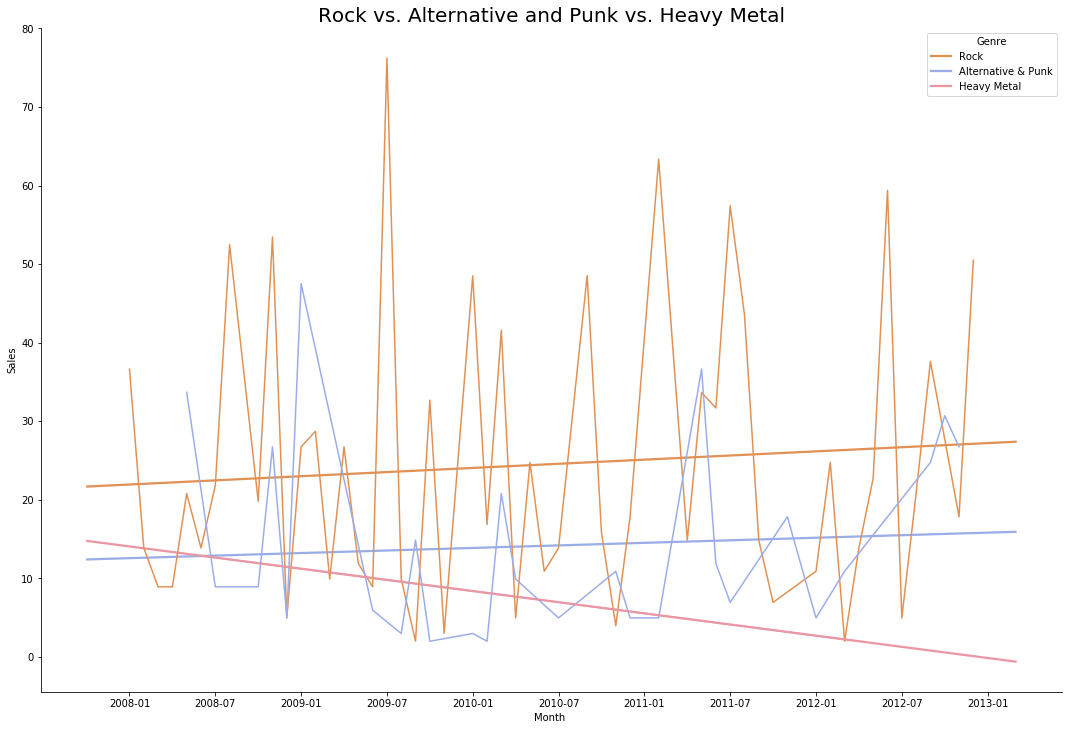

In [9]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.lmplot(x='order', y='Sales', hue='Genre', data=df_3genres_summary, ci=None, scatter=False,
           height=10, aspect=1.5, legend_out=False, palette=colorset2)
ax = sns.lineplot(x='order', y='Sales', hue='Genre', data=df_3genres_summary, legend=False, palette=colorset2)
plt.title('Rock vs. Alternative and Punk vs. Heavy Metal', size=20)
plt.xlabel('Month ')
month_year = pd.period_range(start='01-2008', periods=11, freq='6M').astype(str)
ax.set(xticks=np.arange(0,66,6), xticklabels=month_year);

### Plot 4: Tree Plot

In [10]:
import matplotlib
import squarify

df_tree = df_EA.groupby(['Country', 'Region'])['Sales'].sum().reset_index()
df_tree['Sales'] = df_tree['Sales'] / df_tree['Sales'].sum() * 100
df_tree.sort_values(by=['Region', 'Sales'], inplace=True)
labels = [f"{label[0]}\n{label[1]:.2f}%" for label in zip(df_tree['Country'], df_tree['Sales'])]

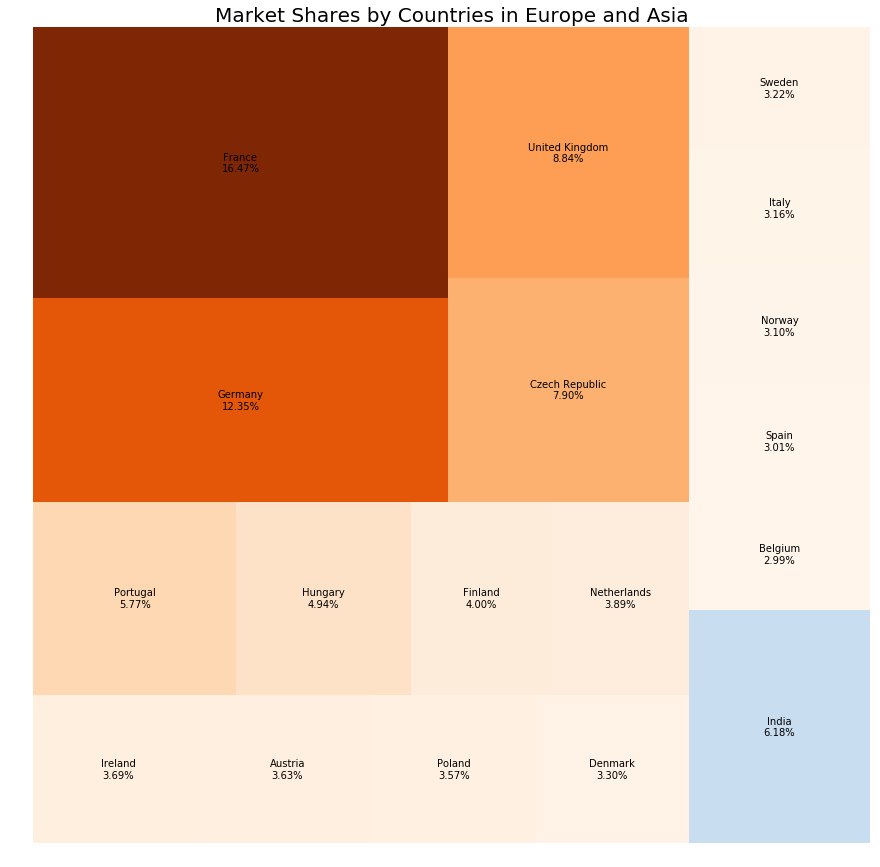

In [11]:
cmap1 = matplotlib.cm.Oranges
cmap2 = matplotlib.cm.Blues
mini=min(df_tree['Sales'])
maxi=max(df_tree['Sales'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap1(norm(value)) if region == 'Europe' else cmap2(norm(value)) 
          for value, region in zip(df_tree['Sales'], df_tree['Region'])]
plt.figure(figsize=(15,15))
squarify.plot(sizes=df_tree['Sales'], label=labels , color=colors, )
plt.title('Market Shares by Countries in Europe and Asia', size=20)
plt.gca().invert_xaxis()
plt.axis('off');

### Plot 5: Scatter Plot

In [12]:
df['Bytes'] = df['Bytes'].str.extract('(\d*\.?\d*)', expand=False).astype(float)
df['Seconds'] = df['Milliseconds']/1000

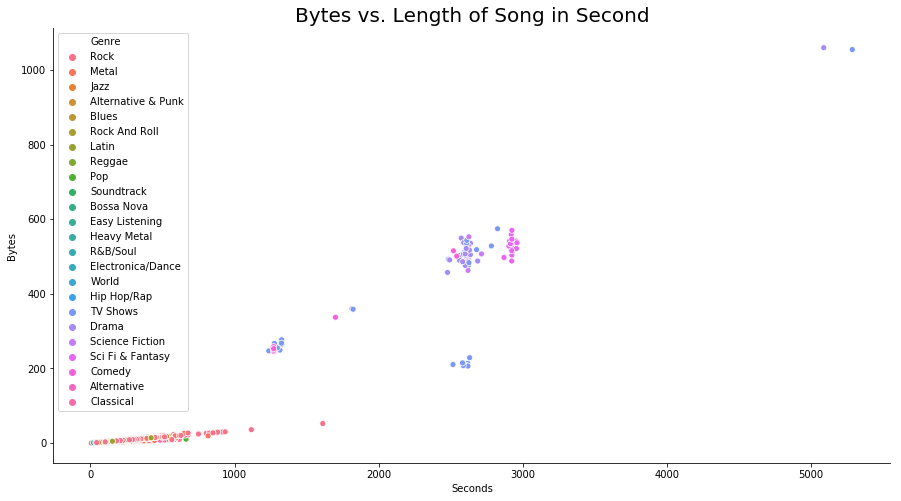

In [13]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(x='Seconds', y='Bytes', hue='Genre', data=df)
plt.title('Bytes vs. Length of Song in Second', size=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Data for Plot 6 - 10

In [14]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target

### Plot 6: Univariate Distribution Plot

C:\Users\daytoda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


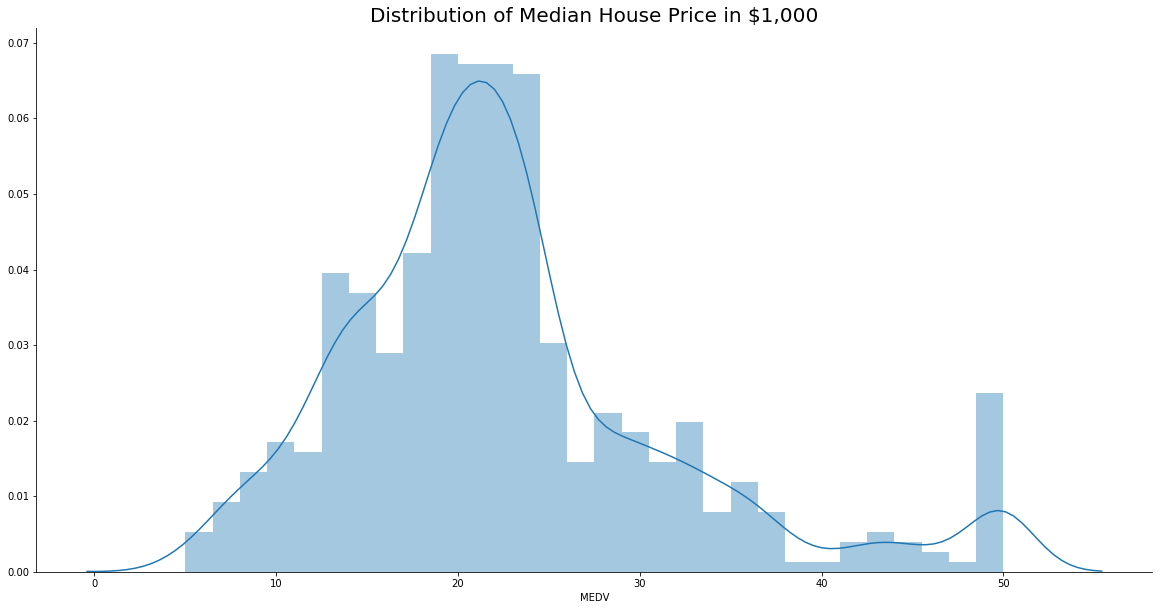

In [15]:
ax = sns.distplot(boston['MEDV'], bins=30)
plt.title('Distribution of Median House Price in $1,000', size=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Plot 7: Diagonal Heatmap

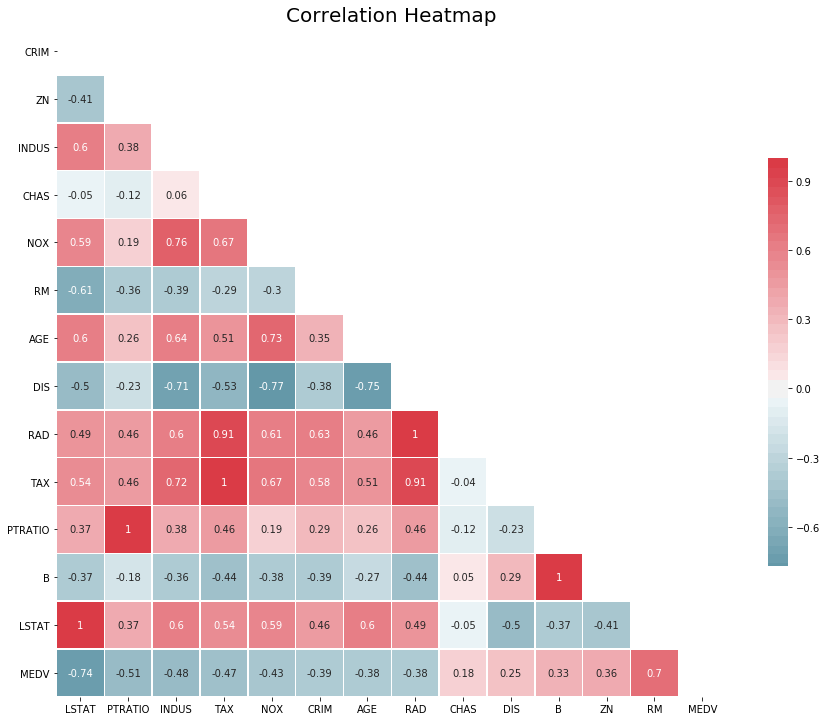

In [16]:
corr_matrix = boston.corr().round(2)
corr1 = corr_matrix.sort_values(by='MEDV', axis=1, ascending=False)
corr_matrix = corr1.sort_values(by='MEDV', axis=1, ascending=True)

plt.figure(figsize=(15,15))
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, n=50)
ax = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.yticks(rotation=0)
ax.set_title('Correlation Heatmap',fontsize=20)
ax.tick_params(labelsize=10)

### Plot 8: Vertical Bar Plot

In [17]:
im = ax.collections[0]
rgba_values = im.cmap(im.norm(im.get_array()))
feat = corr_matrix['MEDV'].sort_values()
color = rgba_values[-14:-1]
colors = []
for c in color:
    colors.append(tuple(c))
feat_df = None
feat_df = feat.drop(index='MEDV', axis=0).reset_index()
feat_df['color'] = colors

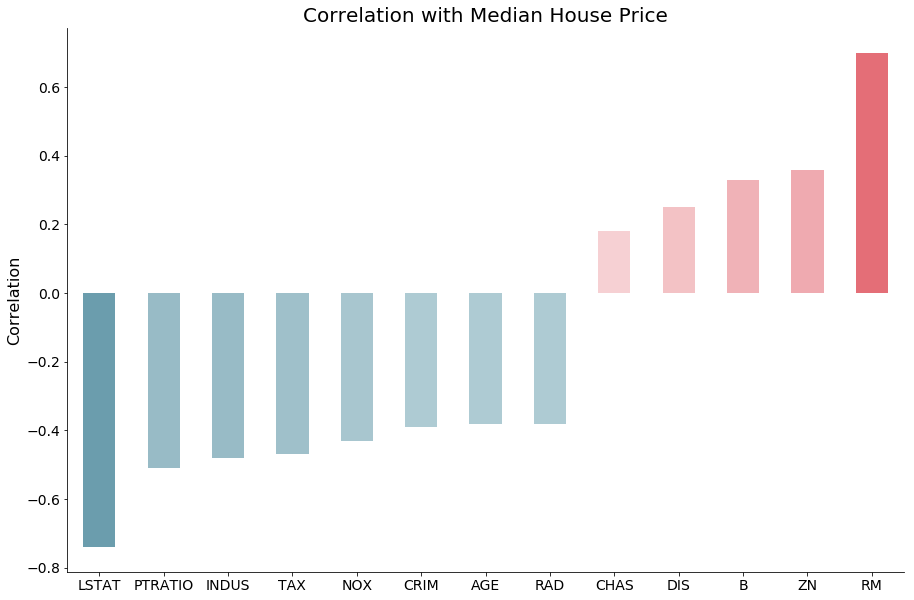

In [18]:
ax = feat_df.plot.bar(x='index', y='MEDV', figsize=(15,10), fontsize=12, color=colors)
plt.xticks(rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Correlation',fontsize=16)
ax.set_title('Correlation with Median House Price',fontsize=20)
ax.tick_params(labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().remove()
fig = ax.get_figure()
fig.savefig("corr_br.png", bbox_inches = 'tight',
    pad_inches = 0.1)

### Plot 9: Pair Plot on Highest and Lowest Correlated Features

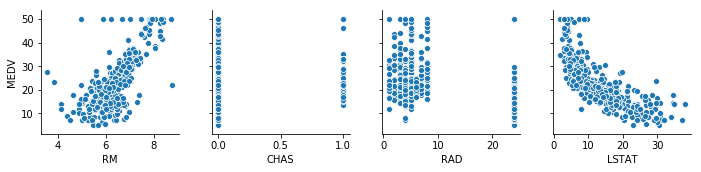

In [19]:
sns.pairplot(boston, x_vars=['RM', 'CHAS', 'RAD', 'LSTAT'], y_vars='MEDV')

### Plot 10: Parallel Coordinates

In [20]:
from sklearn.preprocessing import MinMaxScaler
mmss = MinMaxScaler()
mmss_boston = mmss.fit_transform(boston)
mmss_boston_df = pd.DataFrame(mmss_boston, index=boston.index, columns=boston.columns)

feat2 = corr_matrix['MEDV'].abs().sort_values(ascending=False)
feat_df2 = feat2.drop(index='MEDV', axis=0).reset_index()
order = feat_df2['index'].tolist()
order.append('MEDV')
mmss_boston_df = mmss_boston_df[order]

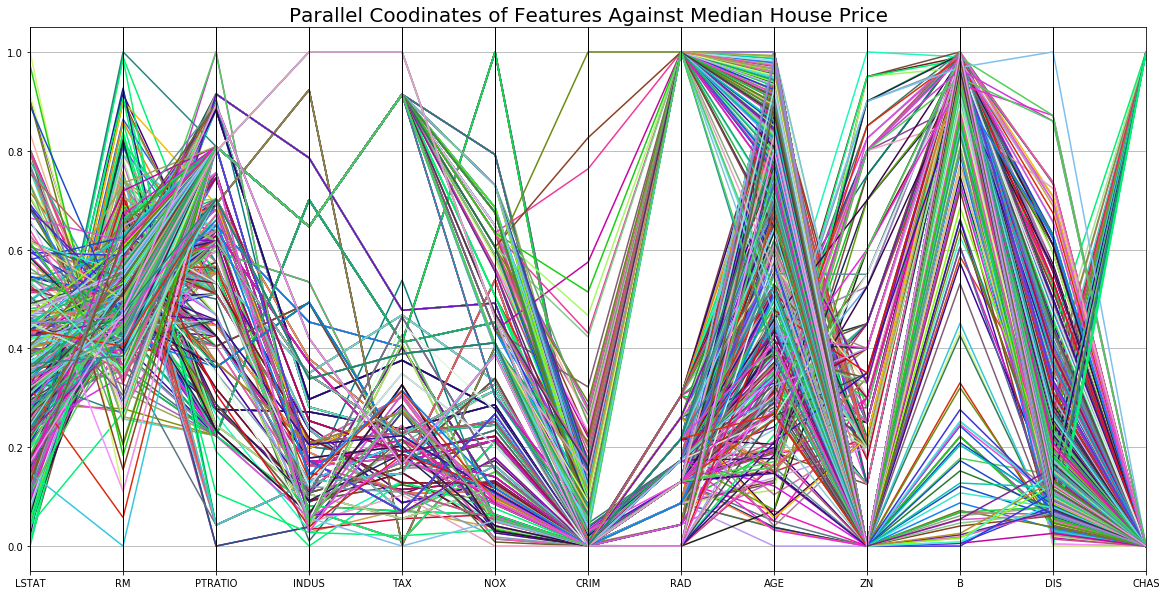

In [21]:
plt.figure(figsize=(20,10))
ax = pd.plotting.parallel_coordinates(mmss_boston_df, 'MEDV')
ax.set_title('Parallel Coodinates of Features Against Median House Price',fontsize=20)
ax.legend().remove()